In [178]:
import numpy as np 
import scipy as sp
import pandas as pd
from scipy.optimize import root
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
from numpy.linalg import eigvals
from scipy.signal import savgol_filter 
from scipy.optimize import root_scalar

# Maier Saupe Model 

The free energy is given by: 
$$ 
f(t,\overline{\mu}, Q_{\mu\nu}) = + \frac{1}{2}\sum_{\mu,\nu}Q^2_{\mu\nu} - t\ln \left[ 3 + e^{-\frac{\overline{\mu}}{t} - \frac{1}{2t}\sum_\mu Q_{\mu\mu}}\sum_{\mu}e^{\frac{3}{2t}Q_{\mu\mu}} \right]
$$
where $\mu=x,y,z$. Here we perform the chenge of variables $S \equiv Q_{zz}$ and $\eta \equiv Q_{yy} - Q_{xx}$

#### If $S\neq 0$ and $\eta = 0$

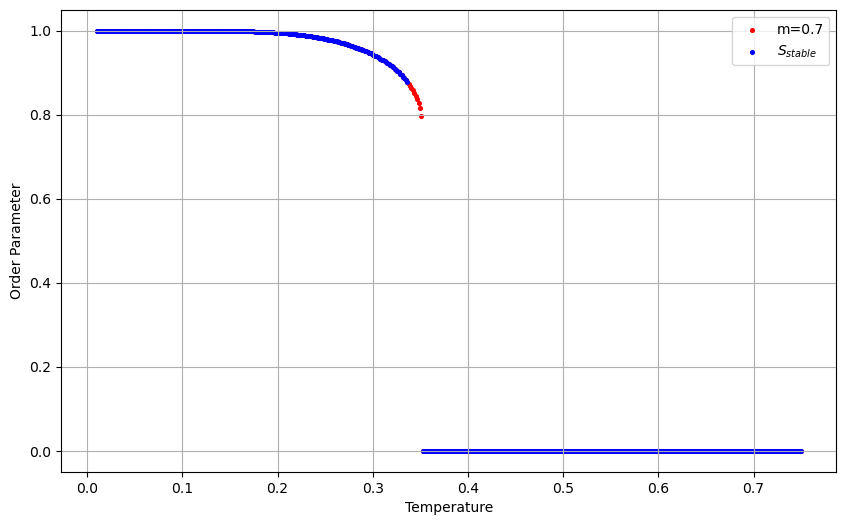

In [ ]:
def first_eqs(t,m,S):     
    exp1=np.exp((9/4)*S/t)
    exp2=np.exp((1/4)*(S+4*m)/t) 

    nom = 1 - exp1
    denom = 2 + exp1 + 3*exp2

    return nom/denom + S 

def hessian(t,m,S): 
    exp1=np.exp((9/4)*S/t)
    exp2=np.exp((3*S+4*m)/(4*t))
    exp3=np.exp((3*S+m)/t)

    # Define the denominator
    denominator = 4*t*(2+exp1+3*exp2)**2
    denominator2= 2*t*(2+exp1+3*exp2)**2

    # Define the elements of the Hessian matrix 
    H11 = 1 - 3*(3+3*exp1+5*exp2+exp3)/denominator
    H12 = (9 - 3*exp2*(-4 + exp1))/denominator
    H13 = (9*exp1+3*exp2+6*exp3)/denominator
    H33 =  1 - (9*exp1 + 6*exp3 + 3*exp2)/denominator2


    # Construct the Hessian matrix using numpy
    hessian_matrix = np.array([[H11, H12, H13],
                            [H12, H11, H13],
                        [H13, H13, H33]])
    
    return hessian_matrix


eigenvalues=[] 
def stability_check(t,m,S): 
    eigen_values = eigvals(hessian(t,m,S))
    eigenvalues.append(eigen_values)

    return False if any(i < 0 for i in eigen_values) else True

m=0.7

T_vals = np.linspace(0.01, 0.75, 500)
S_vals = []

S_vals = []
for T in T_vals:
    # Solve for S
    sol = root_scalar(lambda S: first_eqs(T, m, S), method='newton', x0= S_vals[-1] if S_vals else 1.0)

    if sol.converged:
        S_vals.append(sol.root)
    else:
        # Try fallback
        sol = root_scalar(lambda S: first_eqs(T, m, S), method='bisect', bracket=[-1.0, 2.0])
        if sol.converged:
            S_vals.append(sol.root)
        else:
            S_vals.append(np.nan)  # Mark failure

S_stable=[]
T_stable=[]

for i in range(len(T_vals)): 
    if stability_check(T_vals[i],m ,S_vals[i]):
        S_stable.append(S_vals[i]) 
        T_stable.append(T_vals[i]) 


# Plot
fig=plt.figure(figsize=(10, 6))

plt.scatter(T_vals, S_vals, label=f'm={m}', color='red',s=7)
plt.scatter(T_stable, S_stable, label=r'$S_{stable}$', color='blue',s=7) 

plt.xlabel('Temperature')
plt.ylabel('Order Parameter')
plt.legend()
plt.grid(True) 
plt.show() 

In [182]:
####### Generating Experiments Files
def first_eqs(t,m,S): 
    exp1=np.exp((9/4)*S/t)
    exp2=np.exp((3*S+4*m)/(4*t)) 

    nom = 1 - exp1
    denom = 2 + exp1 + 3*exp2

    return nom/denom + S 

def hessian(t,m,S): 
    exp1=np.exp((9/4)*S/t)
    exp2=np.exp((3*S+4*m)/(4*t))
    exp3=np.exp((3*S+m)/t)

    # Define the denominator
    denominator = 4*t*(2+exp1+3*exp2)**2
    denominator2= 2*t*(2+exp1+3*exp2)**2

    # Define the elements of the Hessian matrix 
    H11 = 1 - 3*(3+3*exp1+5*exp2+exp3)/denominator
    H12 = (9 - 3*exp2*(-4 + exp1))/denominator
    H13 = (9*exp1+3*exp2+6*exp3)/denominator
    H33 =  1 - (9*exp1 + 6*exp3 + 3*exp2)/denominator2

    # Construct the Hessian matrix using numpy
    hessian_matrix = np.array([[H11, H12, H13],
                            [H12, H11, H13],
                        [H13, H13, H33]])
    
    return hessian_matrix

def stability_check(t, m, S, tol=1e-6): 
    eigen_values = eigvals(hessian(t, m, S))
    eigenvalues.append(eigen_values)

    return all(ev > -tol for ev in eigen_values)

eigenvalues=[]
m_sample = np.linspace(0.01, 0.75, 500)  
n = len(m_sample)
stability_map = np.full((n, n), 0, dtype=float)  # Start with NaN instead of zeros

for line, m in enumerate(m_sample):
    T_vals = np.linspace(0.01, 0.75, 500)
    S_vals = []

    for t in T_vals:
        # Solve for S
        sol = root_scalar(lambda S: first_eqs(t, m, S), method='newton', x0= S_vals[-1] if S_vals else 1.0)

        if sol.converged:
            S_vals.append(sol.root)
        else:
            # Try fallback
            sol = root_scalar(lambda S: first_eqs(t, m, S), method='bisect', bracket=[-1.0, 2.0])
            if sol.converged:
                S_vals.append(sol.root)
            else:
                S_vals.append(np.nan)  # Mark failure

    for column, (t, S) in enumerate(zip(T_vals, S_vals)):
        if stability_check(t, m, S):
            stability_map[line, column] = S  # Only assign if stable

    # Saving stable points for each m
    stable_indices = np.where(~np.isnan(stability_map[line]))
    S_stable = stability_map[line][stable_indices]
    T_stable = T_vals[stable_indices]

    np.savetxt(f'Data/Uniaxial_{line+1}.csv', np.column_stack((S_stable, T_stable)), 
               delimiter=' ', fmt='%f', header=f'Constant m: {m}\nS_vals T_vals')

np.savetxt('Stability_map.txt', stability_map, delimiter=' ', fmt='%f')


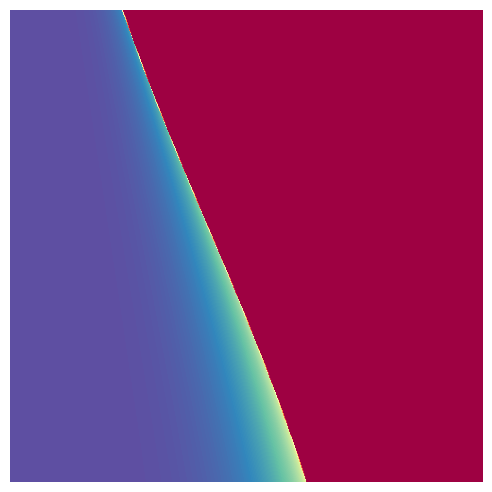

In [183]:
data = np.loadtxt("Stability_map.txt")
data = np.ma.masked_invalid(data) 

cmap='Spectral'
cm = 1/2.54
plt.figure(figsize=(12*cm, 12*cm))  # Adjust for output size in cm
plt.imshow(data, origin='lower', cmap=cmap, extent=[0, 500, 0, 500])
plt.axis('off')  
plt.tight_layout(pad=0)
plt.savefig("heatmap.png", dpi=600, bbox_inches='tight', pad_inches=0, transparent=True)

#### Import colormap
cmap = plt.get_cmap(cmap)
n = 100  # Number of color sample
with open("Spectral_colormap.tex", "w") as f:
    f.write("\\pgfplotsset{\n    colormap={Spectral}{%\n")
    for i in range(n):
        r, g, b, _ = cmap(i / (n - 1))
        f.write(f"        rgb({i})=({r:.4f},{g:.4f},{b:.4f})")
        if i != n - 1:
            f.write(",\n")
        else:
            f.write("\n")
    f.write("    }\n}\n")


In [184]:
####### Reading Files 
def file_reader(index): 
    file_path = f'Data/Uniaxial_{index}.csv' 
    data = np.loadtxt(file_path, delimiter=' ', skiprows=2) 
    
    # Extract columns
    S_vals = data[:, 0]
    T_vals = data[:, 1]

    return S_vals, T_vals 

def free_energy(t,S,m): 
    exp1=np.exp(-(3*S+4*m)/(4*t))
    exp2=np.exp((9/4)*S/t) 

    return (3/4)*S**2 - t*np.log(3+exp1*(2+exp2))    

T_c= []
for i,m in enumerate(m_sample, 1): 
    S_vals, T_vals = file_reader(i)      
    delta_e=[] 

    for i in range(len(T_vals)):     
        t=T_vals[i]
        S=S_vals[i] 
    
        delta = free_energy(t,S,m) + t*np.log(3+3*np.exp(-m/t))
        delta_e.append(delta)

    for i in range(len(delta_e) - 1):
        if delta_e[i] < 0 and delta_e[i + 1] >= 0:
            transition_index = i + 1  
            break
    
    transition_temperature = T_vals[transition_index] 
    T_c.append(transition_temperature) 


### Smothing the curve 

<>:8: SyntaxWarning: invalid escape sequence '\m'
<>:8: SyntaxWarning: invalid escape sequence '\m'
/var/folders/1q/ck574qds4v36l1t2j4jftvq80000gn/T/ipykernel_36099/2235101515.py:8: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel('$\mu$')


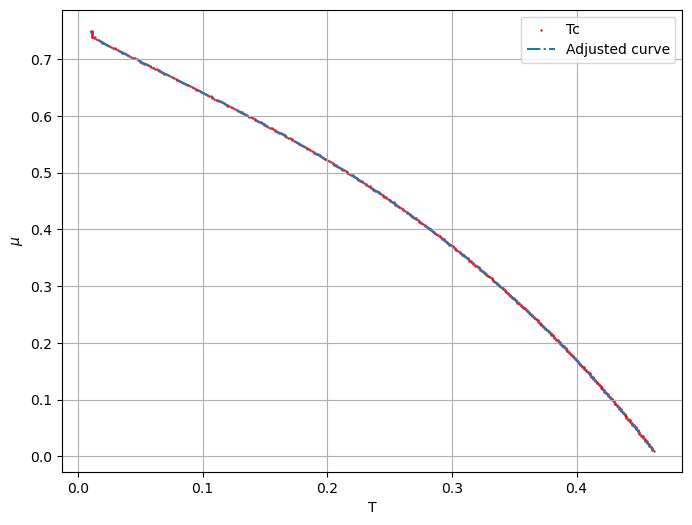

In [185]:
Tc_hat = savgol_filter(T_c, 51, 3) # window size 51, polynomial order 3  

fig3=plt.figure(figsize=(8, 6))

plt.scatter(T_c, m_sample, label='Tc',color='red',s=0.5) 
plt.plot(Tc_hat, m_sample, '-.', label='Adjusted curve')  

plt.ylabel('$\mu$')
plt.xlabel('T')
plt.legend()
plt.grid(True) 
plt.show() 

data2 = np.column_stack((Tc_hat, m_sample))
np.savetxt('DMS_data', data2 , delimiter=' ', fmt='%f')  

### Energy Analysis

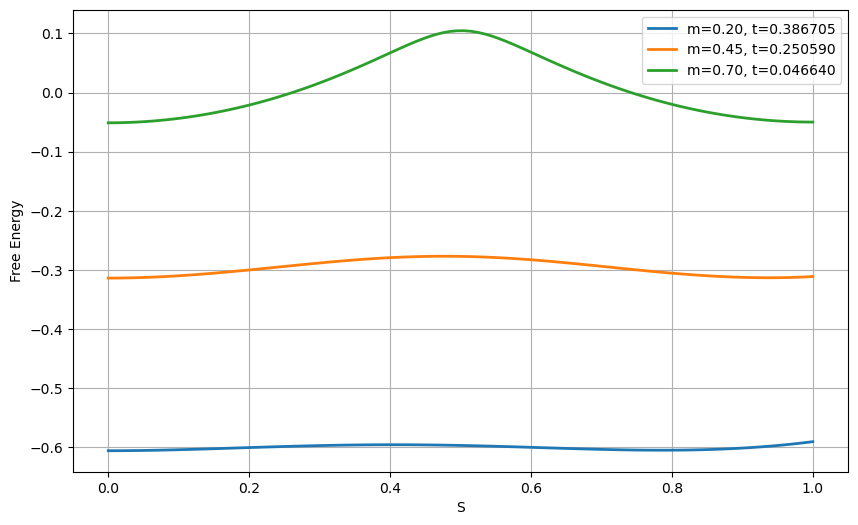

In [209]:
def free_energy(t,S,m): 
    exp1=np.exp(-(3*S+4*m)/(4*t))
    exp2=np.exp((9/4)*S/t) 

    return (3/4)*S**2 - t*np.log(3+exp1*(2+exp2))    

def find_nearest(array, value):     
    array = np.asarray(array)   
    idx = (np.abs(array - value)).argmin()    
    return idx

i=0
m_sample = np.linspace(0.01, 0.75, 500)  
m_vals= [0.2, 0.45, 0.7]
t_sample= [Tc_hat[find_nearest(m_sample,m_vals[0])], Tc_hat[find_nearest(m_sample,m_vals[1])], Tc_hat[find_nearest(m_sample,m_vals[2])]] 
S_sample= np.linspace(0.0, 1.0, 100) 

fig=plt.figure(figsize=(10, 6))

for m,t in zip(m_vals,t_sample): 
    energy = []
    i+=1
     
    for s in S_sample:
        energy.append(free_energy(t,s,m))

    #Save the data     
    data = np.column_stack((S_sample, energy))
    np.savetxt(f'DMS_Energy_{i}', data , delimiter=' ', fmt='%f') 
    
    # Plot the curves
    plt.plot(S_sample, energy, linewidth=2, label=f'm={m:.2f}, t={t:.6f}')

# Plot settings
plt.xlabel('S')
plt.ylabel('Free Energy')
plt.grid(True)
plt.legend()
plt.show()

In [206]:
Tc_hat
m_sample

[0.2, 0.45, 0.7]

In [205]:
m_vals= [0.2, 0.45, 0.7]
t_sample= [Tc_hat[find_nearest(m_sample,m_vals[0])], Tc_hat[find_nearest(m_sample,m_vals[1])], Tc_hat[find_nearest(m_sample,m_vals[2])]]  

print(Tc_hat)
print(t_sample)

[0.46184905 0.4613013  0.46075522 0.46021071 0.45966766 0.45912596
 0.45858552 0.45804621 0.45750795 0.45697061 0.45643409 0.4558983
 0.45536311 0.45482843 0.45429415 0.45376017 0.45322637 0.45269265
 0.4521589  0.45162503 0.45109091 0.45055645 0.45002154 0.44948608
 0.44894995 0.44841306 0.44788229 0.44730866 0.44677722 0.44624628
 0.44571367 0.44517719 0.44459516 0.44405264 0.44350793 0.44295885
 0.44240323 0.44184743 0.44128929 0.44072661 0.44020528 0.43963588
 0.4390643  0.43853642 0.43796283 0.43742887 0.43684518 0.43625763
 0.4357121  0.43511918 0.43456426 0.43400599 0.43340301 0.43284071
 0.43227774 0.43171226 0.43114241 0.43052685 0.42995097 0.4293734
 0.42879232 0.42820586 0.42762074 0.42703512 0.42644716 0.42585499
 0.42525678 0.42465925 0.42406053 0.4234588  0.42290026 0.42229584
 0.42173126 0.42111743 0.42050057 0.41992692 0.41930738 0.41872767
 0.41814679 0.41756322 0.41697544 0.41634246 0.41574998 0.41515699
 0.41456198 0.41396345 0.41335987 0.41274974 0.41214011 0.411529